In [92]:
import numpy as np
import sunpy
import sunpy.map
from sunpy.coordinates import propagate_with_solar_surface
from sunkit_image import coalignment
import astropy
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord
from astropy.visualization import (ImageNormalize, AsinhStretch,
                                  PercentileInterval)
import matplotlib.pyplot as plt
from glob import glob
import os
from sun_blinker import SunBlinker
from tqdm import tqdm

In [2]:
saffron_dir = '../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221024T231535_V07_150995398-000/con-06/'

In [3]:
saffron_NeVIII_con06_file = glob(os.path.join(saffron_dir, '*770.42-ne_8*.fits'))[0]
saffron_OIII_con06_files = glob(os.path.join(saffron_dir, '*o_3*.fits'))
saffron_NIV_con06_file = glob(os.path.join(saffron_dir, '*765.15-n_4*.fits'))[0]

In [4]:
saffron_NeVIII_con06_maps = sunpy.map.Map(saffron_NeVIII_con06_file)
saffron_NeVIII_con06_intensity_map = saffron_NeVIII_con06_maps[0]

saffron_OIII_intensity = []
for file_ in saffron_OIII_con06_files:
    saffron_OIII_con06_maps = sunpy.map.Map(file_)
    saffron_OIII_intensity.append(saffron_OIII_con06_maps[0].data)
saffron_OIII_con06_intensity_map = sunpy.map.Map(np.nansum(saffron_OIII_intensity, axis=0), saffron_OIII_con06_maps[0].meta)

saffron_NIV_con06_maps = sunpy.map.Map(saffron_NIV_con06_file)
saffron_NIV_con06_intensity_map = saffron_NIV_con06_maps[0]

In [5]:
for maps in (saffron_NeVIII_con06_intensity_map, saffron_OIII_con06_intensity_map, saffron_NIV_con06_intensity_map):
    maps.plot_settings['aspect'] = maps.scale.axis2/maps.scale.axis1
    maps.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(maps.data, 0.2),
                                                vmax=np.nanpercentile(maps.data, 99.8),
                                                stretch=AsinhStretch())

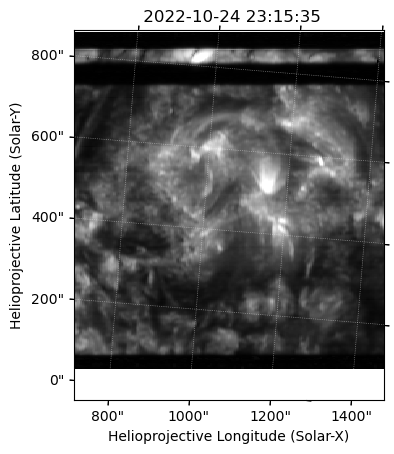

In [6]:
saffron_NeVIII_con06_intensity_map.plot()

In [37]:
saffron_NeVIII_con06_intensity_map.meta['date-end']

'2022-10-25T02:28:23.515'

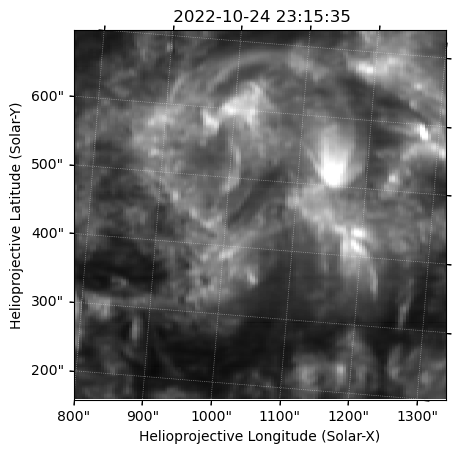

In [52]:
saffron_NeVIII_con06_intensity_map_crop = saffron_NeVIII_con06_intensity_map.submap(SkyCoord(800*u.arcsec, 
                                                                                             200*u.arcsec, 
                                                                                             frame=saffron_NeVIII_con06_intensity_map.coordinate_frame),
                                                                                    top_right = SkyCoord(1300*u.arcsec,700*u.arcsec,
                                                                                            frame=saffron_NeVIII_con06_intensity_map.coordinate_frame))
saffron_NeVIII_con06_intensity_map_crop.plot()

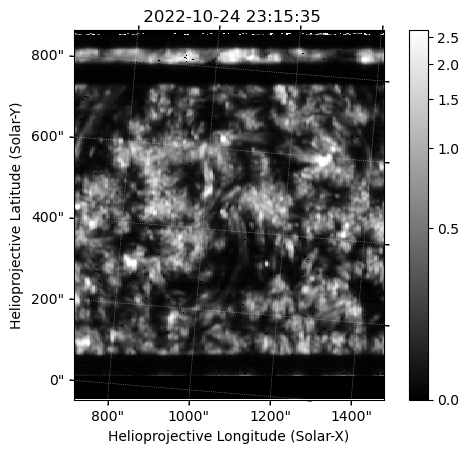

In [53]:
saffron_OIII_con06_intensity_map.plot()
plt.colorbar()

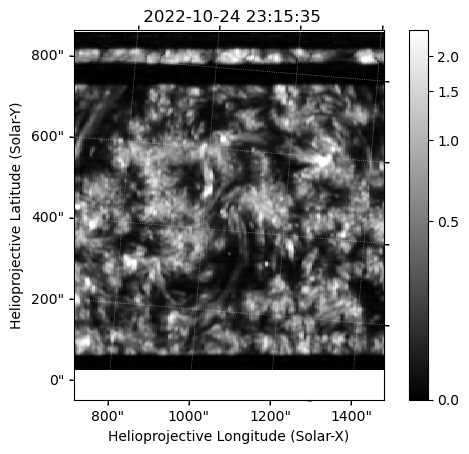

In [54]:
saffron_NIV_con06_intensity_map.plot()
plt.colorbar()

In [55]:
fsi_174_map_antoine = sunpy.map.Map('../../src/EUI/FSI/euv174/20221024/for_spice_syn/solo_L3_FSI174-image-composed-2022-10-25T00_51_57.fits')
fsi_174_map_antoine.plot_settings['aspect'] = fsi_174_map_antoine.scale.axis2/fsi_174_map_antoine.scale.axis1

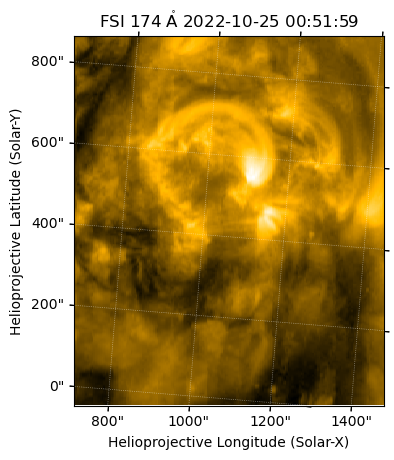

In [56]:
fsi_174_map_antoine.plot()

In [88]:
fsi_174_map_antoine.world_to_pixel(SkyCoord(800*u.arcsec, 300*u.arcsec, frame=fsi_174_map_antoine.coordinate_frame))

PixelPair(x=<Quantity 27.41683965 pix>, y=<Quantity 308.31402595 pix>)

In [89]:
fsi_174_map_antoine.world_to_pixel(SkyCoord(1300*u.arcsec, 800*u.arcsec, frame=fsi_174_map_antoine.coordinate_frame))

PixelPair(x=<Quantity 162.22865295 pix>, y=<Quantity 724.88655294 pix>)

In [85]:
fsi_174_map_antoine_copy = sunpy.map.Map(fsi_174_map_antoine.data, fsi_174_map_antoine.meta)
test_rotation_angle = 30*u.deg
rotate_matrix_multiply = np.array([[np.cos(np.deg2rad(test_rotation_angle)), 
                                    -np.sin(np.deg2rad(test_rotation_angle))*(fsi_174_map_antoine.meta['cdelt2']/fsi_174_map_antoine.meta['cdelt1'])],
                                    [np.sin(np.deg2rad(test_rotation_angle))*(fsi_174_map_antoine.meta['cdelt1']/fsi_174_map_antoine.meta['cdelt2']),
                                    np.cos(np.deg2rad(test_rotation_angle))]])
fsi_174_map_new_rotation_matrix = np.matmul(rotate_matrix_multiply, fsi_174_map_antoine_copy.rotation_matrix)

fsi_174_map_antoine_copy.meta['pc1_1'] = fsi_174_map_new_rotation_matrix[0,0]
fsi_174_map_antoine_copy.meta['pc1_2'] = fsi_174_map_new_rotation_matrix[0,1]
fsi_174_map_antoine_copy.meta['pc2_1'] = fsi_174_map_new_rotation_matrix[1,0]
fsi_174_map_antoine_copy.meta['pc2_2'] = fsi_174_map_new_rotation_matrix[1,1]

fsi_174_map_antoine_copy.plot_settings['aspect'] = fsi_174_map_antoine_copy.scale.axis2/fsi_174_map_antoine_copy.scale.axis1

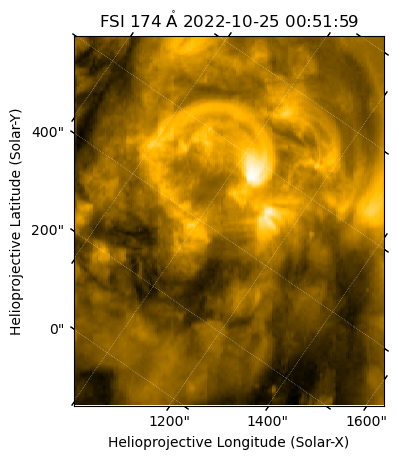

In [86]:
fsi_174_map_antoine_copy.plot()

In [57]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift

In [110]:
def change_crota(reference_map, coalign_map,
                 reference_map_bottom_left, reference_map_top_right,
                 crota_variations=np.linspace(-1,1,11)):

    reference_map_cutout = reference_map.submap(reference_map_bottom_left, top_right=reference_map_top_right)
    Txshifts = []
    Tyshifts = []
    chi2s = []
    
    for crota_variation in tqdm(crota_variations):
        rotate_matrix_multiply = np.array([[np.cos(np.deg2rad(crota_variation)), 
                                    -np.sin(np.deg2rad(crota_variation))*(coalign_map.meta['cdelt2']/coalign_map.meta['cdelt1'])],
                                    [np.sin(np.deg2rad(crota_variation))*(coalign_map.meta['cdelt1']/coalign_map.meta['cdelt2']),
                                    np.cos(np.deg2rad(crota_variation))]])
        
        coalign_map_rotate = sunpy.map.Map(coalign_map.data, coalign_map.meta)
        coalign_map_new_rotation_matrix = np.matmul(rotate_matrix_multiply, coalign_map.rotation_matrix)

        coalign_map_rotate.meta['pc1_1'] = coalign_map_new_rotation_matrix[0,0]
        coalign_map_rotate.meta['pc1_2'] = coalign_map_new_rotation_matrix[0,1]
        coalign_map_rotate.meta['pc2_1'] = coalign_map_new_rotation_matrix[1,0]
        coalign_map_rotate.meta['pc2_2'] = coalign_map_new_rotation_matrix[1,1]

        coalign_map_template = coalign_map_rotate.reproject_to(reference_map_cutout.wcs)

        Txshift, Tyshift = coalign_shift(reference_map, coalign_map_template)

        Txshifts.append(Txshift)
        Tyshifts.append(Tyshift)

        coalign_map_rotate_shifted = coalign_map_rotate.shift_reference_coord(Txshift, Tyshift)
        coalign_map_rotate_shifted_reprojected = coalign_map_rotate_shifted.reproject_to(reference_map_cutout.wcs)

        chi2s.append(np.sum((reference_map_cutout.data - coalign_map_rotate_shifted_reprojected.data)**2))
    
    return Txshifts, Tyshifts, crota_variations, chi2s

In [112]:
def apply_rotate_and_shifts(map, rotate_angle, Txshift, Tyshift):
    rotate_matrix_multiply = np.array([[np.cos(np.deg2rad(rotate_angle)), 
                                    -np.sin(np.deg2rad(rotate_angle))*(map.meta['cdelt2']/map.meta['cdelt1'])],
                                    [np.sin(np.deg2rad(rotate_angle))*(map.meta['cdelt1']/map.meta['cdelt2']),
                                    np.cos(np.deg2rad(rotate_angle))]])
    map_rotate = sunpy.map.Map(map.data, map.meta)
    map_rotate.plot_settings = map.plot_settings
    map_new_rotation_matrix = np.matmul(rotate_matrix_multiply, map.rotation_matrix)

    map_rotate.meta['pc1_1'] = map_new_rotation_matrix[0,0]
    map_rotate.meta['pc1_2'] = map_new_rotation_matrix[0,1]
    map_rotate.meta['pc2_1'] = map_new_rotation_matrix[1,0]
    map_rotate.meta['pc2_2'] = map_new_rotation_matrix[1,1]

    map_rotate_shifted = map_rotate.shift_reference_coord(Txshift, Tyshift)

    return map_rotate_shifted

In [113]:
Txshift_NeVIII_all, Tyshift_NeVIII_all, crota_NeVIII_all, chi2_NeVIII_all = change_crota(fsi_174_map_antoine, saffron_NeVIII_con06_intensity_map,
                                                                        SkyCoord(800*u.arcsec, 300*u.arcsec, frame=fsi_174_map_antoine.coordinate_frame),
                                                                        SkyCoord(1300*u.arcsec, 800*u.arcsec, frame=fsi_174_map_antoine.coordinate_frame))

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:05<00:00,  2.17it/s]


In [114]:
NeVIII_shift_best_index = np.argmin(chi2_NeVIII_all)
NeVIII_shift_best_index

2

In [115]:
saffron_NeVIII_con06_intensity_map_shifted = apply_rotate_and_shifts(saffron_NeVIII_con06_intensity_map, crota_NeVIII_all[NeVIII_shift_best_index], 
                                                                     Txshift_NeVIII_all[NeVIII_shift_best_index], 
                                                                     Tyshift_NeVIII_all[NeVIII_shift_best_index])

In [116]:
SunBlinker(fsi_174_map_antoine, saffron_NeVIII_con06_intensity_map_shifted, reproject=True)